In [1]:
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson
from astroML.datasets import generate_mu_z

from sklearn.model_selection import train_test_split
from sklearn.gaussian_process import GaussianProcessRegressor, kernels

In [2]:

def cross_validate(x,y,test_size,show_figures):
    d = np.arange(0,10)
    X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=test_size)
    training_err = np.zeros(d.shape)
    crossval_err = np.zeros(d.shape)

    for i in range(len(d)):
        p = np.polyfit(X_train, y_train, d[i])
        training_err[i] = np.sqrt(np.sum((np.polyval(p, X_train) - y_train) ** 2)/ len(y_train))
        crossval_err[i] = np.sqrt(np.sum((np.polyval(p, X_valid) - y_valid) ** 2)/ len(y_valid))
    
    
    degree=d[np.where(crossval_err==np.min(crossval_err))]
    
    if show_figures=='yes':
        
        plt.plot(d,training_err,'-k',label='training_err')
        plt.plot(d,crossval_err,'--k',label='crossval_err')
        plt.axvline(x=degree,color='red',label='correct degree')
        plt.title('cross validation with a test size of '+str(test_size))
        plt.legend()
        plt.show()
    
    return(degree)

def fit_and_show(x,y,deg):
    model = PolynomialRegression(deg)
    model.fit(z_sample[:,None], mu_sample)
    x_pred=np.linspace(0,np.max(z_sample),1000)
    y_pred = model.predict(x_pred[:,None])
    plt.plot(x_pred,y_pred,color='red')
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.scatter(z_sample,mu_sample)
    return(model.coef_)

Text(0, 0.5, '$\\mu$')

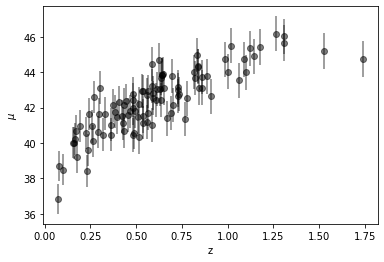

In [3]:
#generating data

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

#plotting data

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5);
plt.xlabel("z")
plt.ylabel("$\mu$")

## Linear regression

39.56505554722625 4.647118479591295


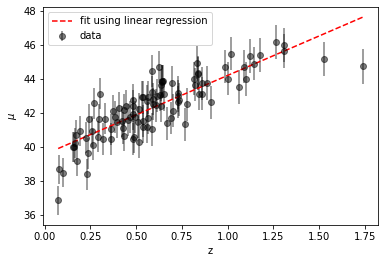

In [4]:
#Defining the regressor and fitting

regressor = LinearRegression()
regressor.fit(z_sample[:,None], mu_sample, sample_weight=1.0)

#Getting the model parameters

theta0 = regressor.intercept_
theta1 = regressor.coef_
print(theta0, theta1[0])

#Defining a grid and making predictions using the model just found

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),100)
y_pred=regressor.predict(xgrid[:,None])

#Plotting

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.5,label='data');
plt.plot(xgrid,y_pred,color='red',linestyle='--',label='fit using linear regression')

plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend()
plt.show()

## Polynomial regression

order 2 polynomial


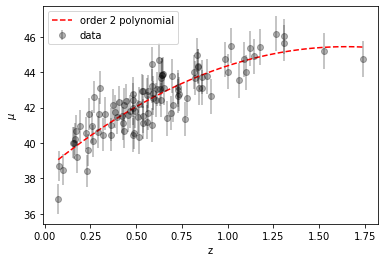

order 3 polynomial


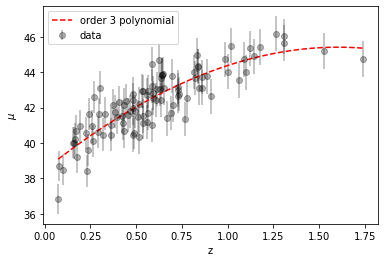

order 4 polynomial


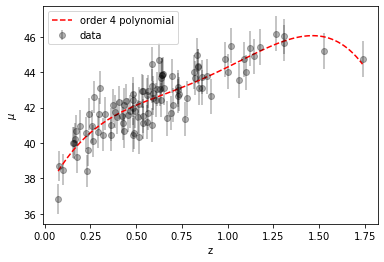

order 5 polynomial


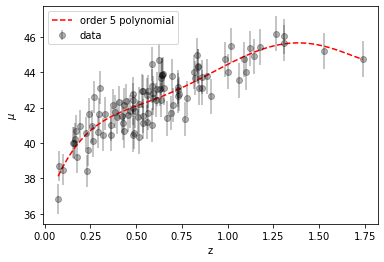

order 6 polynomial


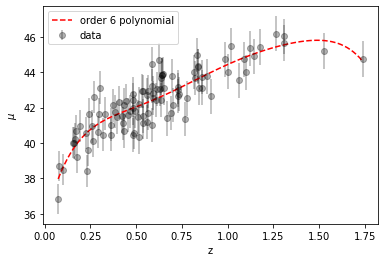

order 7 polynomial


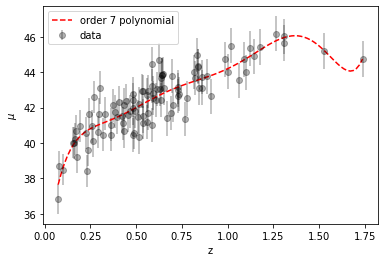

order 8 polynomial


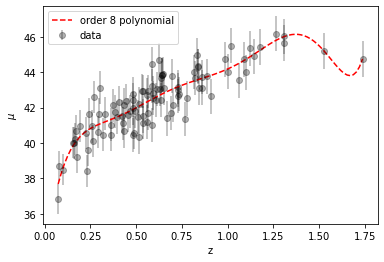

order 9 polynomial


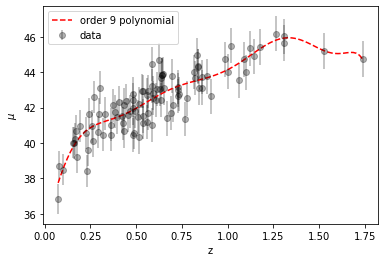

order 10 polynomial


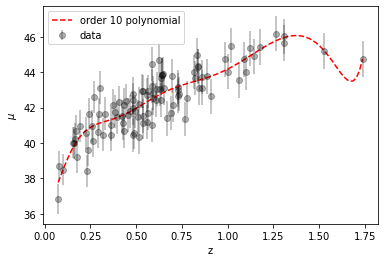

In [5]:
#defining a grid

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),100)

#fitting using different degrees

for degree in range(2,11):
    
    #defining the regressor
    
    regressor = PolynomialRegression(degree) 
    regressor.fit(z_sample[:,None], mu_sample)
    
    #making predictions
    
    y_pred=regressor.predict(xgrid[:,None])
    print('order '+str(degree)+' polynomial')
    
    #plotting, for more clarity I plot each fit separetely
    
    plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.3,label='data');
    plt.plot(xgrid,y_pred,color='red',linestyle='--',label=('order '+str(degree)+' polynomial'))
    plt.xlabel("z")
    plt.ylabel("$\mu$")
    plt.legend()
    plt.show()




Looking at the plots it seems that the best fits are the ones of order 3 and 4, at order 1 (linear regression) or 2 it seems we are underfitting while for orders bigger than 4 it seems we are overfitting.

## Fitting using cross-validation

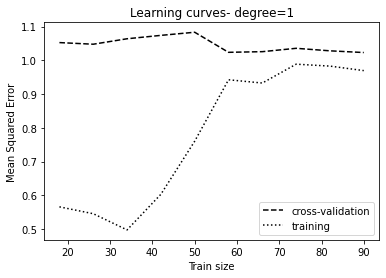

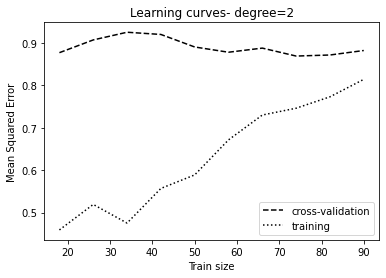

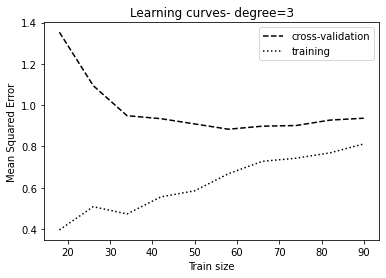

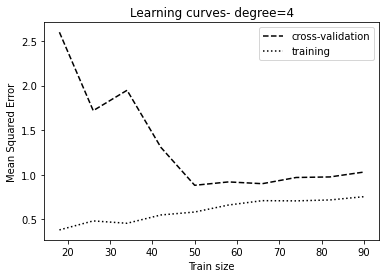

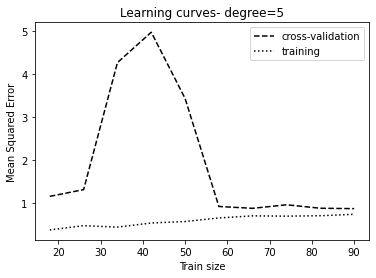

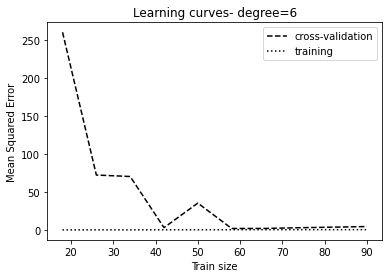

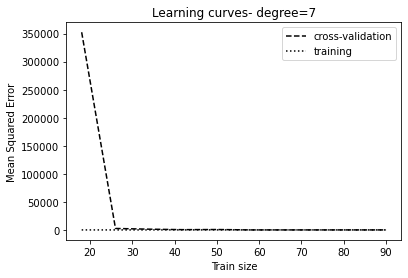

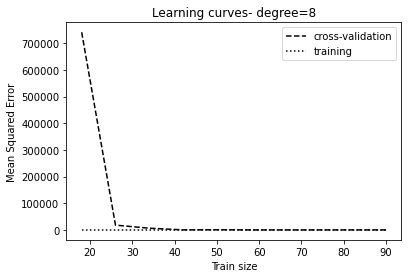

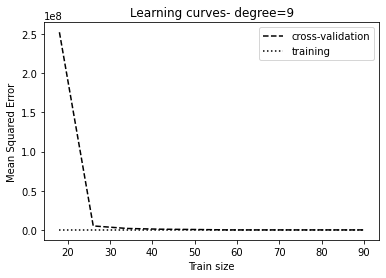

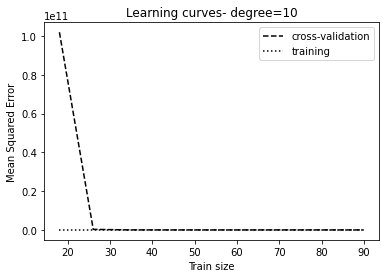

In [6]:
#plotting learning curves for degrees in range(1,10)

for d in range(1,11):
    
    #defining the regressor
    
    regressor = PolynomialRegression(d)
    
    #computing the errors for the training and validation sets using cross_validation
    
    train_sizes, train_scores_regr, test_scores_regr =learning_curve(regressor, z_sample[:,None], mu_sample, train_sizes=np.linspace(0.2, 1, 10), \
        scoring="neg_mean_squared_error", cv=10)
    
    #plotting the learning curves
    
    plt.plot(train_sizes, -test_scores_regr.mean(1),linestyle='--',color='black', label='cross-validation')
    plt.plot(train_sizes, -train_scores_regr.mean(1), linestyle=':',color='black' ,label='training')
                       
    plt.xlabel("Train size")
    plt.ylabel("Mean Squared Error")
    plt.title('Learning curves- degree='+str(d))
    plt.legend(loc="best")
    plt.show()


From the learning curves it seems that at a training size of 0.8 all the curves are converging thus I choose 0.2 as a test size for the following cell

The best degree is:  4


array([ 37.0543994 ,  20.74217865, -32.83020744,  27.30599762,
        -7.98337391])

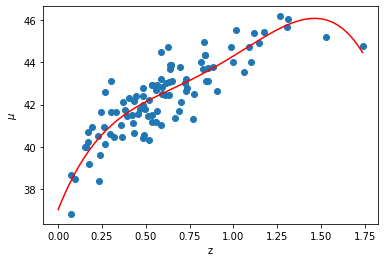

In [7]:
#doing a lot of cross_validations as defined from my function to find the best degree for our polynomial

#computing the best degree

deg=np.array([cross_validate(z_sample,mu_sample,0.2,'no') for i in range (0,1000)])

print('The best degree is: ',int(np.mean(deg)))

#fitting and plotting the result

fit_and_show(z_sample,mu_sample,int(np.mean(deg)))


Best Polynomial Degree: 5


array([ 36.18760445,  31.00142053, -69.82397489,  82.84185044,
       -44.24104125,   8.47059008])

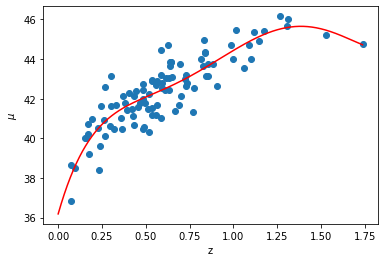

In [8]:
# Trying to find the best degree using cross_validation by GridSearchCV

#definig the regressor

regressor=PolynomialRegression()

#defining degrees to be tested

degrees=np.arange(1,10,1)
param_grid = {'degree': degrees}

#searching for the best degree

grid_search = GridSearchCV(estimator=regressor, scoring="neg_mean_squared_error",param_grid=param_grid, cv=10)
grid_search.fit(z_sample[:,None], mu_sample)


best_degree = grid_search.best_params_['degree']
print("Best Polynomial Degree:", best_degree)

fit_and_show(z_sample,mu_sample,best_degree)

## Basis function regression

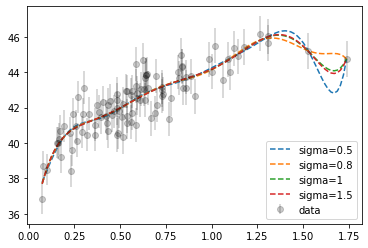

In [30]:
#defining a grid

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),100)

#fitting using different sigmas for the regressor

for s in [0.5,0.8,1,1.5]:
    
    #definig the regressor and fitting
    #here I'll use gaussians
    
    regressor = BasisFunctionRegression('gaussian', mu=z_sample[0:10,None], sigma=s)
    regressor.fit(z_sample[:,None], mu_sample, dmu)
    
    #predicting values
    
    y_pred = regressor.predict(xgrid[:,None])

    #plotting
    
    plt.plot(xgrid,y_pred,linestyle='--',label='sigma='+str(s))

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.2,label='data');
plt.legend()
plt.show()


## Fitting using Kernel regression

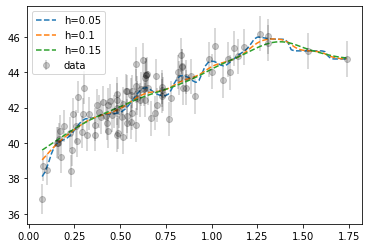

In [31]:
#defining the grid

xgrid=np.linspace(np.min(z_sample),np.max(z_sample),100)

#fitting using different h

for h in [0.05,0.1,0.15]:
    
    #definig the regressor and fitting
    
    regressor = NadarayaWatson(kernel='gaussian', h=h)
    regressor.fit(np.column_stack((z_sample,z_sample)),mu_sample)
    
    #predicting
    
    y_pred = regressor.predict(np.column_stack((xgrid,xgrid)))
    
    #plotting
    
    plt.plot(xgrid,y_pred,linestyle='--',label='h='+str(h))

plt.errorbar(z_sample,mu_sample,dmu,color='black',fmt="o",alpha=0.2,label='data');
plt.legend()
plt.show()

## Fitting using Gaussian process regressor

In [ ]:
kernel1 = kernels.RBF(2, (2, 2))
kernel2 = kernels.RationalQuadratic(length_scale=0.5, alpha=1.5)
gp1 = GaussianProcessRegressor(kernel=kernel1,random_state=0, normalize_y=True)
gp2 = GaussianProcessRegressor(kernel=kernel2,random_state=0, normalize_y=True)
gp1.fit(z_sample[:, None], mu_sample)
gp2.fit(z_sample[:, None], mu_sample)

In [ ]:
x=np.linspace(0,1.75,100)
f1, f1_err = gp1.predict(x[:, None], return_std=True)
f2, f2_err = gp2.predict(x[:, None], return_std=True)
plt.plot(x,f1,color='green')
plt.plot(x,f2,color='red')
plt.errorbar(z_sample,mu_sample,dmu,fmt='.', ecolor='gray', lw=1,label='data')
#params=fit_and_show(z_sample,mu_sample,int(np.mean(deg)))
plt.show()